<a href="https://colab.research.google.com/github/ZacharySBrown/vcu-scma440-2021q1/blob/master/examples/4b_holt_winters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Fetch Data
Press the play button in Google Colab or press Shift+Enter execute the cell below to download and load the data and packages for this assignment

This will load four pandas DataFrame objects: `shampoo`,`housing`, `airline`, and `airline_series`, and `quarterly_sales` Each of these is used in Makridakis Chapters 3 and 4.

In [135]:
import pandas as pd
from numpy import abs
from numpy import log, abs, mean, exp
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16



!curl https://raw.githubusercontent.com/ZacharySBrown/vcu-scma440-2021q1/master/utils/fetch_e4.sh > fetch_e4.sh
!bash fetch_e4.sh

# Example
shampoo = pd.read_csv('shampoo_sales.csv', parse_dates=['date']).set_index('date')
housing = pd.read_csv('housing_sales.csv', parse_dates=['date']).set_index('date')
airline = pd.read_csv('airline.csv').set_index('year')
airline_series = pd.read_csv('airline_series.csv', parse_dates=['date']).set_index('date')
can_openers = pd.read_csv('can_openers.csv', parse_dates=['month']).set_index('month')
quarterly_sales = pd.read_csv('quarterly_sales.csv', parse_dates=['date']).set_index('date')

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   586  100   586    0     0   2844      0 --:--:-- --:--:-- --:--:--  2844
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   629  100   629    0     0   1877      0 --:--:-- --:--:-- --:--:--  1872
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3867  100  3867    0     0  12514      0 --:--:-- --:--:-- --:--:-- 12514
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   456  100   456    0     0   1485      0 --:--:-- --:--:-- --:--:--  1485
  % Total    % Received % Xferd  Average Speed   Tim

# Insepcting the Data
Let's first start by taking a look at the `shampoo` and `quarterly_sales` data

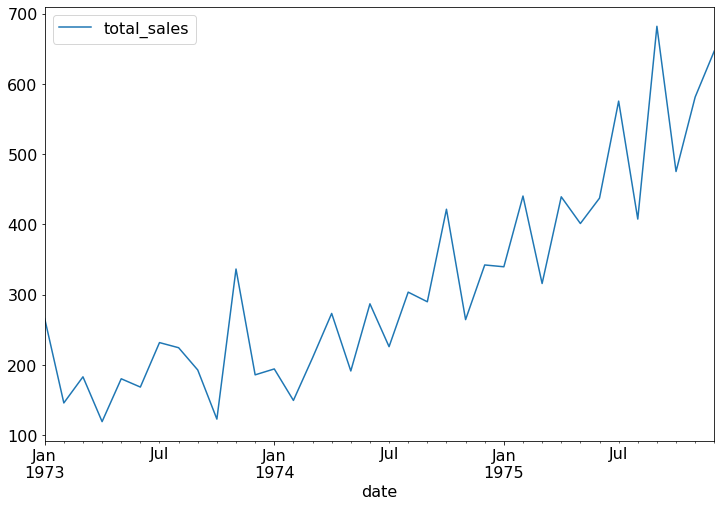

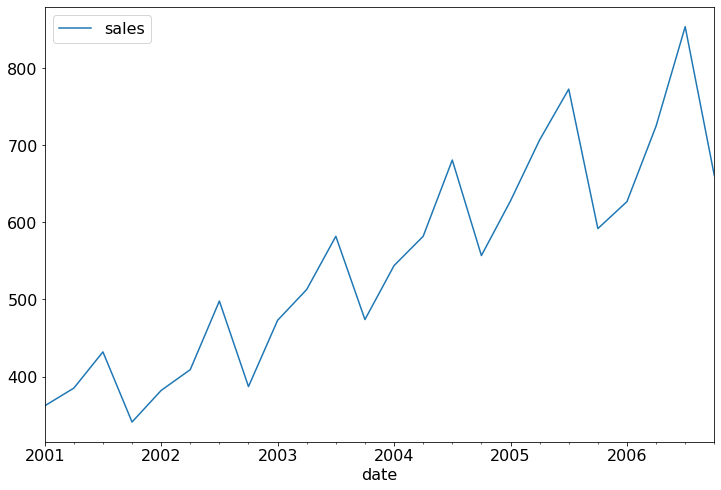

In [9]:
shampoo.plot()
quarterly_sales.plot()


In the monthly shampoo sales data, we observe a definitly upward trend, and in the quarterly sales data, we observe a trend as well as a seasonal component. 

Below we'll apply Holt's linear method to produce a smoothed forecast for the shampoo data, and Holt-Winter's smoothing to generate a forecast for the quarterly sales data. 

# Holt's Linear Method

To implement Holt's linear method, we can use the `Holt` model from `statsmodels.tsa`:

```
from statsmodels.tsa.api import Holt
```

To create an instance of the model, you can simply pass in the data to be fit to the model class:

```
model = Holt(data['my_column'])
```

In [58]:
model = Holt(shampoo['total_sales'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


To fit the model to your data, you call the `.fit()` function, which accepts the following arguments:

* `smoothing_level`: Value of $\alpha$
* `smoothing_slope`: Value of $\beta$
* `initial_level`: Initial value for level
* `initial_slope`: Initial value for the slope
* `optimized`: Estimate model parameters by maximizing the log-likelihood

We can fully specify every open parameter of the model, or alternately determine optimal parameters for the model by minimizing the SSE. 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:720: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  warn(message, EstimationWarning)


,name,param,optimized
smoothing_level,alpha,0.1,False
smoothing_slope,beta,0.5,False
initial_level,l.0,266.0,False
initial_slope,b.0,-120.1,False


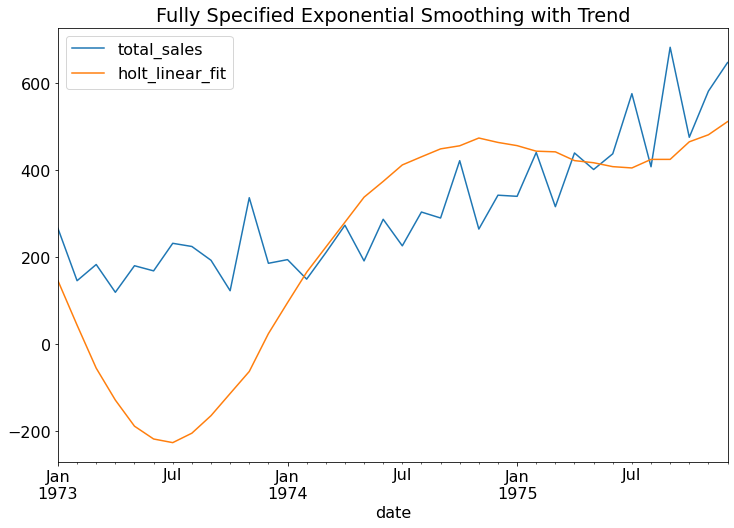

In [36]:
initial_level = shampoo['total_sales'].values[0]
initial_slope = shampoo['total_sales'].values[1] - shampoo['total_sales'].values[0]

results = model.fit(
    smoothing_level=0.1, 
    smoothing_slope=0.5,
    initial_level = initial_level,
    initial_slope = initial_slope
    )


shampoo['holt_linear_fit'] = results.fittedvalues

my_figure = shampoo.plot()

plt.title('Fully Specified Exponential Smoothing with Trend')

display(results.params_formatted)

We can also let the model optimize the parameters

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,name,param,optimized
smoothing_level,alpha,0.473684,True
smoothing_slope,beta,0.473684,True
initial_level,l.0,266.000000,True
initial_slope,b.0,0.000000,True


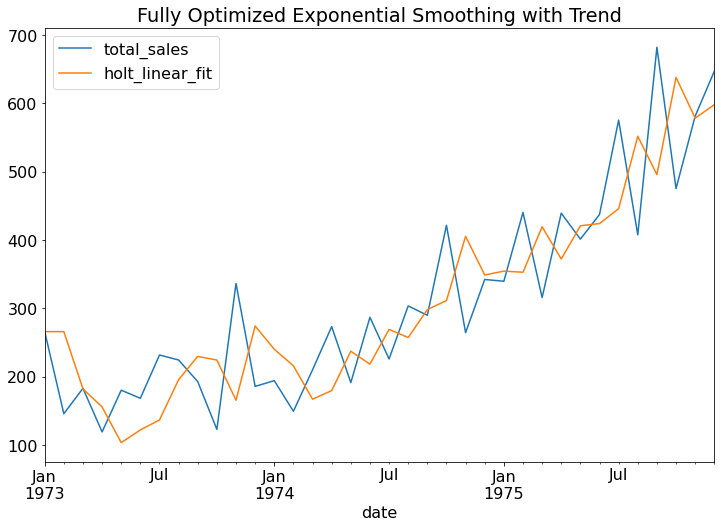

In [35]:
initial_level = shampoo['total_sales'].values[0]
initial_slope = shampoo['total_sales'].values[1] - shampoo['total_sales'].values[0]

results = model.fit()


shampoo['holt_linear_fit'] = results.fittedvalues

my_figure = shampoo.plot()

plt.title('Fully Optimized Exponential Smoothing with Trend')

display(results.params_formatted)

# Holt-Winter's Method

To implement Holt-Winter's smoothing, we can use the `ExponentialSmoothing` model from `statsmodels.tsa`:

```
from statsmodels.tsa.api import ExponentialSmoothing
```

To create an instance of the model, you pass in the data to be fit to the model class, but there are several more options for this more general exponential smoothing method:

* `trend`: whether the trend is additive (`add`) or multiplicative (`mul`)
* `seasonal`: whether the seasonal is additive (`add`) or multiplicative (`mul`)
* `seasonal_periods`: Number of observations per seasonal period (e.g. 4 for quarterly)

In [150]:
model = ExponentialSmoothing(
    endog=quarterly_sales['sales'], 
    trend='add', 
    seasonal="mul",
    seasonal_periods=4 
    )

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


To fit the model to your data, we again call the `.fit()` function, which accepts `smoothing_seasonal` (the value of $\gamma$) in addition to those found in `Holt`:

* `smoothing_level`: Value of $\alpha$
* `smoothing_slope`: Value of $\beta$
* `smoothing_seasonal`: Value of $\gamma$
* `initial_level`: Initial value for level
* `initial_slope`: Initial value for the slope
* `optimized`: Estimate model parameters by maximizing the log-likelihood

Just as with `Holt`, we can fully specify every open parameter of the model, or alternately determine optimal parameters for the model by minimizing the SSE. 

,name,param,optimized
smoothing_level,alpha,0.500000,False
smoothing_slope,beta,0.500000,False
smoothing_seasonal,gamma,0.500000,False
initial_level,l.0,362.000000,False
initial_slope,b.0,0.000000,False
initial_seasons.0,s.0,0.985894,True
initial_seasons.1,s.1,1.030694,True
initial_seasons.2,s.2,1.166248,True
initial_seasons.3,s.3,0.911218,True


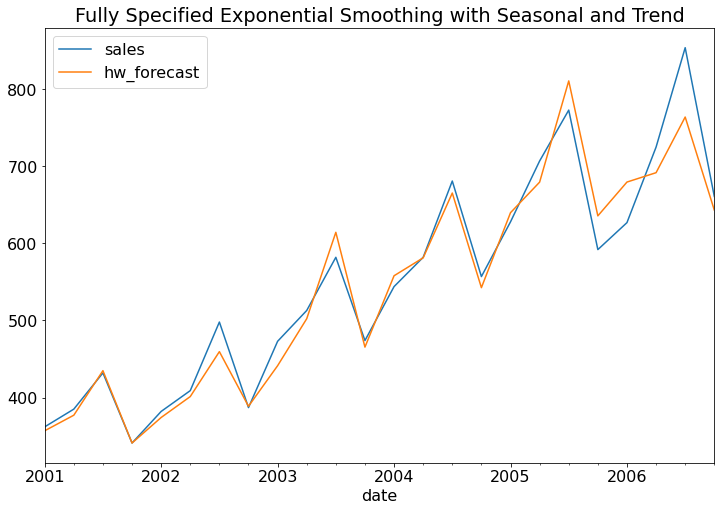

In [151]:
smoothing_level=0.5
smoothing_slope=0.5
smoothing_seasonal = 0.5

initial_level = quarterly_sales['sales'].values[0]
initial_slope = 0

results = model.fit(
    smoothing_level=smoothing_level, 
    smoothing_slope=smoothing_slope, 
    smoothing_seasonal=smoothing_seasonal,
    initial_level=initial_level, 
    initial_slope=initial_slope
)

quarterly_sales['hw_forecast'] = results.fittedvalues    
quarterly_sales.plot()

plt.title('Fully Specified Exponential Smoothing with Seasonal and Trend')

display(results.params_formatted)

,name,param,optimized
smoothing_level,alpha,8.409791e-01,True
smoothing_slope,beta,9.846148e-17,True
smoothing_seasonal,gamma,0.000000e+00,True
initial_level,l.0,5.024096e+02,True
initial_slope,b.0,2.301765e+01,True
initial_seasons.0,s.0,6.812227e-01,True
initial_seasons.1,s.1,7.318932e-01,True
initial_seasons.2,s.2,8.164816e-01,True
initial_seasons.3,s.3,6.244432e-01,True


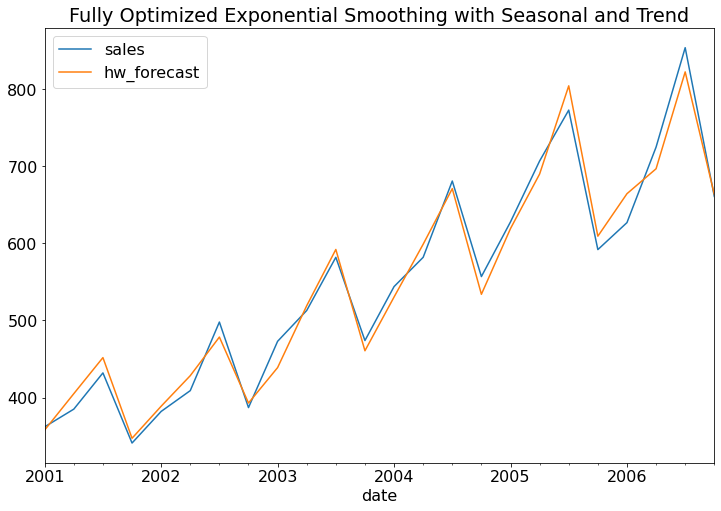

In [152]:
results = model.fit()

quarterly_sales['hw_forecast'] = results.fittedvalues    
quarterly_sales.plot()

plt.title('Fully Optimized Exponential Smoothing with Seasonal and Trend')

display(results.params_formatted)

# Creating Forecasts

To create a new forecast, we can simply call `.forecast(N)` on the results returned by `model.fit()`, where `N` is the number of steps for which you'd like to forecast. 

This will produce a new time series, with values for the next `N` timesteps. 

To compare the original data with the fitted data and forecast, we can append the forecast to the fitted values, to create an extended forecast time series, and plot both that and the original data. 

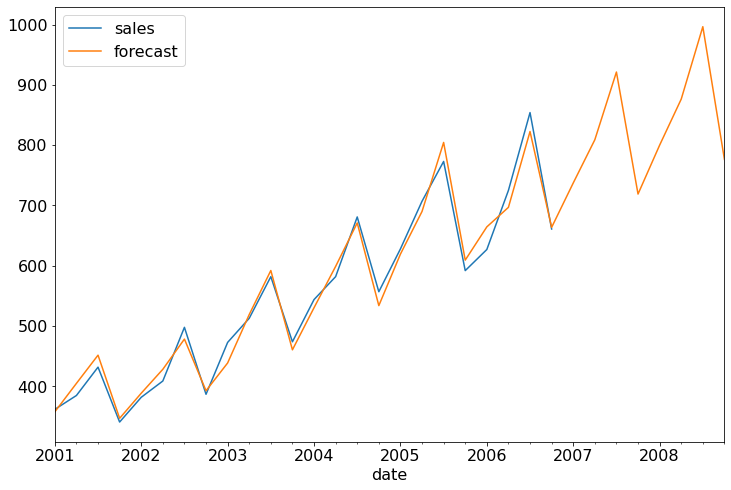

In [161]:
# Create forecast for 8 quarters
forecast_values = results.forecast(8)

# Append the predicted values to the fitted values
forecast = quarterly_sales['hw_forecast'].append(forecast_values)
forecast.name = 'forecast'

# Plot both time series
quarterly_sales['sales'].plot()
forecast.plot()
plt.legend()

TO produce an unbiased estimate on expected real-world predictive performance for our model, we can hold out a portion of our data for a `test` set, and then forecast over that test set and calculate the `MAPE` to quantify goodness of fit. This process is carried out below

In [176]:
# Read in a fresh copy of the data
quarterly_sales = pd.read_csv('quarterly_sales.csv', parse_dates=['date']).set_index('date')

# Specify how many observations we should include in our test set
N = 4

# Separate all but the last N observations 
# to create a train set
train = quarterly_sales['sales'].iloc[:-N]

# Separate off the last N observations
# to create a test set
test = quarterly_sales['sales'].iloc[-N:]

# Create a model using only our train set
model = ExponentialSmoothing(
    endog=train, # NOTE: ONLY TRAIN USED
    trend='add', 
    seasonal="mul",
    seasonal_periods=4 
    )

# Create a fit with specified model parameters
results_specified = model.fit(
    smoothing_level=smoothing_level, 
    smoothing_slope=smoothing_slope, 
    smoothing_seasonal=smoothing_seasonal,
    initial_level=initial_level, 
    initial_slope=initial_slope
)

# Create a fit with optimized model parameters
results_optimized = model.fit()

# Create a forecast with the same number 
# of forecast steps as our test set contains
specified_forecast = results_specified.forecast(N)
optimized_forecast = results_optimized.forecast(N)

# Calculate the MAPE for the specified and optimized forecasts
specified_mape = abs((specified_forecast - test) / test).mean()
optimized_mape = abs((optimized_forecast - test) / test).mean()

print("Specified MAPE: ", specified_mape)
print("Optimized MAPE: ", optimized_mape)

Specified MAPE:  0.04702737599765331
Optimized MAPE:  0.0361997322690607


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


Lastly, we can append the forecasted values to the fit values for each forecast and compare the fit and forecasts to the original series. In the plot below, the last `N` values (`N` specified in the code cell above) are forecasted

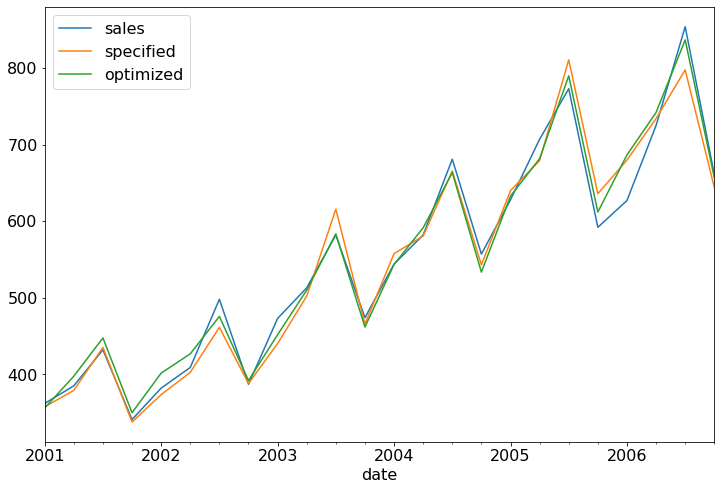

In [178]:
specified_fit_forecast = results_specified.fittedvalues.append(specified_forecast)
specified_fit_forecast.name = 'specified'
optimized_fit_forecast = results_optimized.fittedvalues.append(optimized_forecast)
optimized_fit_forecast.name = 'optimized'

quarterly_sales['sales'].plot()

specified_fit_forecast.plot()

optimized_fit_forecast.plot()

plt.legend()